# AuralSent: Harmonizing Text and Sound for Sentiment Analysis

In [1]:
#!pip install SpeechRecognition
#!pip install librosa

### Data:

https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio/datae

In [2]:
import warnings
warnings.filterwarnings ('ignore')

# Import necessary libraries
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

# Set style for plotting
plt.style.use('seaborn')
sns.set_style('darkgrid')



2024-03-21 16:49:09.598835: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## load data

In [3]:
def extract_features_and_labels(dataset_path):
    features, labels = [], []
    actor_dirs = [adir for adir in os.listdir(dataset_path) if adir.startswith("Actor_")]
    for actor_dir in tqdm(actor_dirs, desc="Actors Progress"):
        actor_path = os.path.join(dataset_path, actor_dir)
        filenames = os.listdir(actor_path)
        for filename in filenames:  # Removed tqdm from this loop for cleaner output
            file_path = os.path.join(actor_path, filename)
            # Extract MFCCs
            y, sr = librosa.load(file_path, sr=None)  # 'sr=None' for the file's original sample rate
            mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
            features.append(mfccs)
            # Extract emotion (3rd item in the filename split by '-')
            labels.append(int(filename.split('-')[2]) - 1)  # Subtract 1 to make labels start from 0
    return np.array(features), to_categorical(np.array(labels))


dataset_path = 'archive/'
features, labels = extract_features_and_labels(dataset_path)


Actors Progress: 100%|██████████████████████████| 24/24 [00:16<00:00,  1.49it/s]


In [4]:
from sklearn.model_selection import train_test_split

# Splitting dataset into training and remainder (test + validation)
X_train, X_remainder, y_train, y_remainder = train_test_split(features, labels, test_size=0.3, random_state=42)

# Splitting remainder into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_remainder, y_remainder, test_size=0.5, random_state=42)


# Reshape X_train, X_val, and X_test to include a time step dimension
X_train = np.expand_dims(X_train, 1)  # Reshaping from (None, 40) to (None, 1, 40)
X_val = np.expand_dims(X_val, 1)
X_test = np.expand_dims(X_test, 1)


## Model

In [22]:

def create_optimized_model(input_shape, num_classes):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.5),
        LSTM(64, return_sequences=False),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Determine the number of unique classes
num_classes = y_train.shape[1]


# Assuming X_train.shape[1:] gives the input shape and 'num_classes' is defined
model = create_optimized_model(X_train.shape[1:], num_classes)

model.summary()

# Define callbacks
callbacks_list = [
    #EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)
]



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 1, 128)            86528     
                                                                 
 batch_normalization_16 (Ba  (None, 1, 128)            512       
 tchNormalization)                                               
                                                                 
 dropout_16 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_17 (LSTM)              (None, 64)                49408     
                                                                 
 batch_normalization_17 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 dropout_17 (Dropout)        (None, 64)               

In [23]:
# Model training
history = model.fit(X_train, y_train, 
                    epochs=1000, 
                    batch_size=8, 
                    validation_split=0.2, 
                    callbacks=callbacks_list, 
                    verbose=1)

Epoch 1/1000
101/101 [==============================] - 4s 14ms/step - loss: 2.4355 - accuracy: 0.1253 - val_loss: 2.0679 - val_accuracy: 0.1337 - lr: 0.0010
Epoch 2/1000
101/101 [==============================] - 1s 7ms/step - loss: 2.1290 - accuracy: 0.1849 - val_loss: 2.0633 - val_accuracy: 0.1436 - lr: 0.0010
Epoch 3/1000
101/101 [==============================] - 1s 6ms/step - loss: 2.0938 - accuracy: 0.1737 - val_loss: 2.0621 - val_accuracy: 0.1238 - lr: 0.0010
Epoch 4/1000
101/101 [==============================] - 1s 7ms/step - loss: 2.0746 - accuracy: 0.1588 - val_loss: 2.0447 - val_accuracy: 0.1485 - lr: 0.0010
Epoch 5/1000
101/101 [==============================] - 1s 7ms/step - loss: 2.0737 - accuracy: 0.1377 - val_loss: 2.0207 - val_accuracy: 0.1782 - lr: 0.0010
Epoch 6/1000
101/101 [==============================] - 1s 6ms/step - loss: 2.0160 - accuracy: 0.1725 - val_loss: 2.2625 - val_accuracy: 0.1337 - lr: 0.0010
Epoch 7/1000
101/101 [==============================] - 1

KeyboardInterrupt: 

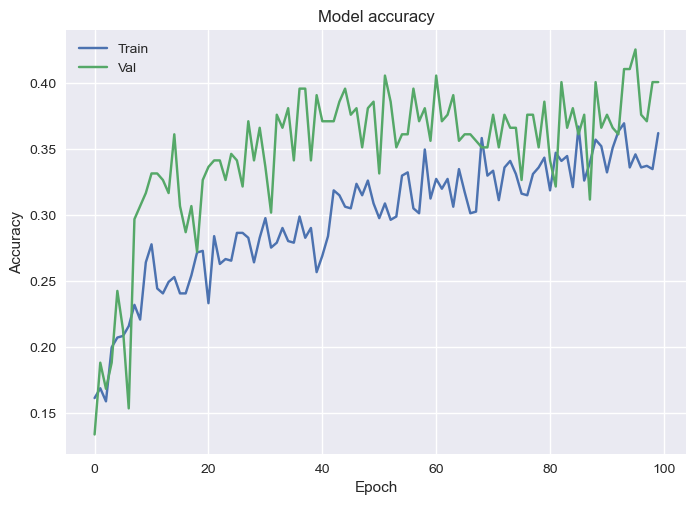

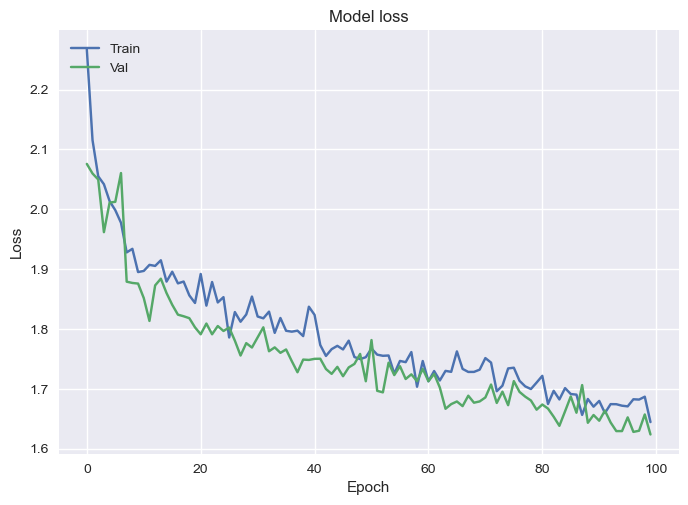

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


### Preprocessing Acoustic Data
Extract Mel-Frequency Cepstral Coefficients (MFCCs) and other relevant features from audio.

In [16]:
import librosa
import numpy as np

def extract_acoustic_features(audio_path):
    y, sr = librosa.load(audio_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    pitch, _ = librosa.piptrack(y=y, sr=sr)
    energy = np.array([
        np.sum(np.abs(y[i:i+512])**2)
        for i in range(0, len(y), 512)
    ])
    return mfccs, pitch, energy


### Text Transcription
Transcribe audio to text using speech recognition.

In [13]:
import speech_recognition as sr

def transcribe_audio(audio_path):
    recognizer = sr.Recognizer()
    with sr.AudioFile(audio_path) as source:
        audio_data = recognizer.record(source)
    try:
        text = recognizer.recognize_google(audio_data)
    except sr.UnknownValueError:
        text = ""
    return text


### [TODO] Align Text with Acoustic Features


This step is conceptual as exact alignment depends on the specific requirements and dataset. One approach is to segment audio at natural speech pauses and extract features per segment, aligning them with transcribed text.

### Step 5: Integrate Acoustic Features into Text Representation
Represent acoustic features in a compatible format for T5. This could involve encoding features numerically and appending them to the text or using special tokens.

In [15]:
def integrate_features_with_text(text, features):
    # Example of simple integration; customize based on your approach
    feature_representation = " ".join([str(f) for f in features])
    return f"{text} [FEATURES] {feature_representation}"
